In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')


In [2]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8 MB 56.4 MB/s eta 0:00:01�████████▉                   | 87.3 MB 54.5 MB/s eta 0:00:03
     |████████████████████████████████| 197 kB 50.0 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=658c630e706ff879aa1ae1c60f66f1621c2647b8ae530db50a72366b8d786056
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/01/c0/03/1c241c9c482b647d4d99412a98a5c7f87472728ad41ae55e1e
Successfully built pyspark


In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

# Ejercicio 3.1

Es tiempo de tomar el archivo PARQUET y crear un dataframe a partir de él. Utilizando SparkSQL puede operarlo como a una base de datos.

In [5]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2021-02-19 19:07:36--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2021-02-19 19:07:36--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2021-02-19 19:07:36--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [6]:
df = spark.read.parquet('washing.parquet')


Veamos cuántas filas tenemos.

In [7]:
df.count()

2058

Registramos el DataFrame en el catálogo de ApacheSparkSQL para que podamos consultar como en SQL.


In [8]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

Visulizames el voltaje mediante un box plot. Primero creamos una lista en python. Recuerde usar la función "sample" para hacer que la cantidad de datos sea manejable.


In [9]:
result = spark.sql("select voltage from washing where voltage is not null")
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#imprimimos los primeros 15 elementos
result_array[:15]

[236, 235, 221, 221, 220, 236, 233, 223, 239, 229, 232, 222, 231, 221, 222]

Para graficar dentro de las celdas:

In [10]:
%matplotlib inline

Ahora realizamos el gráfico.

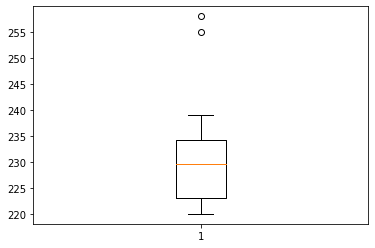

In [11]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

Ya que tratamos con datos de series temporales queremos que entre en juego la dimensión temporal. Los gráficos menos complejos son los "run charts", donde el dominio es representado en el eje x y el eje y muestra el valor del sensor. Hagámoslo para el voltaje.


In [12]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808722910, 1547808791957, 1547808821976, 1547808849030, 1547808858035, 1547808876043, 1547808885074, 1547808897083, 1547809008177, 1547809014196, 1547809017198, 1547809041212, 1547809080236, 1547809083238, 1547809089240]
[221, 238, 230, 238, 228, 221, 226, 223, 244, 255, 250, 235, 235, 224, 227]


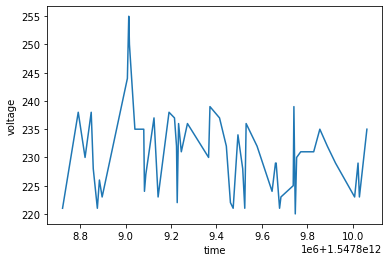

In [13]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

Pero esta vez solo queremos graficar datos por valor de una hora. Por lo tanto, primero tenemos que averiguar en qué rango de fechas tenemos datos disponibles:

In [14]:
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



Ahora mostremos solamente los datos por hora. Aclaremos que "ts" representa "timestamp". Timestamp es el número de milisegundos que pasaron desde el primero de enero de 1970. Puede usar una herramienta online como http://www.epochconverter.com/ para realizar las conversiones. Por ahora alcanza tomar un intervalo de 60 minutos (1000*60*60)=3600000 dentro del rango anterior. Observe que no usamos la función sample porque ya estamos con el dataset reducido. 


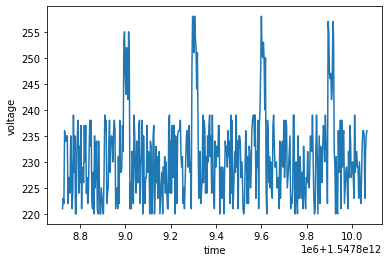

In [15]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

Como puede ver, no solo podemos detectar los valores atípicos, sino que también vemos un patrón de tiempo de estos valores atípicos que se producen y que se pueden utilizar para un análisis posterior posterior.

Hasta ahora graficamos hasta 2 dimensiones a la vez. Hagamos un gráfico de dispersión 3D. Tomemos para ello 3 propiedades:


In [16]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

Realizamos el gráfico:

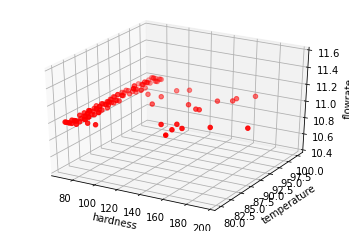

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()

Notará que los puntos individuales se parecen en algún tipo de plano. Pero esto no es una sorpresa. De hecho, podemos sacar las siguientes conclusiones de la trama:

- la mayoría de los puntos están entre una dureza (hardness) de 60-80, temperatura entre 80-100 y flowrate entre 80-100.
- hay algunos outliers, especialmente en el rango de hardness de 100-200
- los datos siguen algunos límites estrechos


Así que comprobemos lo que está pasando con la dureza, ya que parece que realmente se mantiene alrededor de 60-80 y rara vez crea valores por encima de eso. Podemos usar un histograma para aquello que agrupa ciertos rangos de valores y cuenta la frecuencia de aparición de valores dentro de este rango. Esas frecuencias están ordenadas y se muestran como un diagrama de barras, así que trazémoslo:

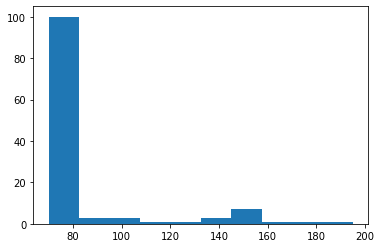

In [18]:
plt.hist(result_array_hardness)
plt.show()

Nuestra suposición era correcta, casi todos los valores están alrededor de 60-80 con valores muy inferiores a ese umbral.
